In [25]:
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
import glob
import sys
import os
import random
import imageio
from skimage.color import rgb2gray
from skimage.metrics import structural_similarity as ssim

%matplotlib inline

## Specify the model to be used
COCO and MPI are body pose estimation model. COCO has 18 points and MPI has 15 points as output.

HAND is hand keypoints estimation model. It has 22 points as output

Ensure that the model files are available in the folders.

In [8]:
MODE = "MPI"

if MODE is "COCO":
    protoFile = "pose/coco/pose_deploy_linevec.prototxt"
    weightsFile = "pose/coco/pose_iter_440000.caffemodel"
    nPoints = 18
    POSE_PAIRS = [ [1,0],[1,2],[1,5],[2,3],[3,4],[5,6],[6,7],[1,8],[8,9],[9,10],[1,11],[11,12],[12,13],[0,14],[0,15],[14,16],[15,17]]

elif MODE is "MPI" :
    protoFile = "pose/mpi/pose_deploy_linevec_faster_4_stages.prototxt"
    weightsFile = "pose/mpi/pose_iter_160000.caffemodel"
    nPoints = 15
    POSE_PAIRS = [[0,1], [1,2], [2,3], [3,4], [1,5], [5,6], [6,7], [1,14], [14,8], [8,9], [9,10], [14,11], [11,12], [12,13] ]
    

In [10]:
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

inWidth = 368
inHeight = 368

#### Load the network and pass the image through the network

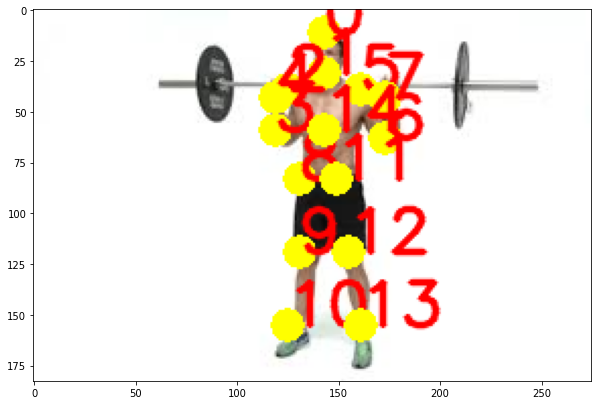

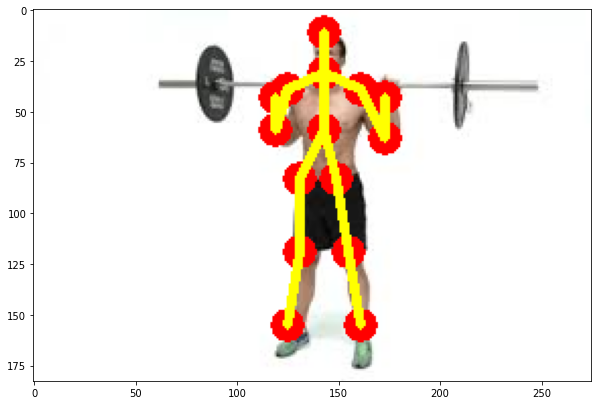

In [11]:
frame = cv2.imread("exercises/squats/3.jpg")
frameCopy = np.copy(frame)
frameBlack = np.zeros(frame.shape)
frameWidth = frame.shape[1]
frameHeight = frame.shape[0]
threshold = 0.1

inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                          (0, 0, 0), swapRB=False, crop=False)

net.setInput(inpBlob)

output = net.forward()
H = output.shape[2]
W = output.shape[3]

# Empty list to store the detected keypoints
points = []

for i in range(nPoints):
    # confidence map of corresponding body's part.
    probMap = output[0, i, :, :]

    # Find global maxima of the probMap.
    minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)
    
    # Scale the point to fit on the original image
    x = (frameWidth * point[0]) / W
    y = (frameHeight * point[1]) / H

    if prob > threshold : 
        cv2.circle(frameCopy, (int(x), int(y)), 8, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
        cv2.putText(frameCopy, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, lineType=cv2.LINE_AA)
        cv2.circle(frameBlack, (int(x), int(y)), 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)
        cv2.circle(frame, (int(x), int(y)), 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)

        # Add the point to the list if the probability is greater than the threshold
        points.append((int(x), int(y)))
    else :
        points.append(None)

# Draw Skeleton
for pair in POSE_PAIRS:
    partA = pair[0]
    partB = pair[1]

    if points[partA] and points[partB]:
        cv2.line(frameBlack, points[partA], points[partB], (0, 255, 255), 3)
        cv2.line(frame, points[partA], points[partB], (0, 255, 255), 3)

plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(frameCopy, cv2.COLOR_BGR2RGB))
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
#plt.imshow(frameBlack.astype(np.uint8))

#### Pass it through the network

#### gather the points and plot the keypoints and the skeleton figure

In [12]:
def blackImager(frame):
    threshold = 0.1
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    frameCopy = np.copy(frame)
    #inputFrameBlack = np.copy(frame)
    inputFrameBlack = np.zeros((frame.shape[0], frame.shape[1]))
    inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                              (0, 0, 0), swapRB=False, crop=False)
    net.setInput(inpBlob)
    output = net.forward()
    H = output.shape[2]
    W = output.shape[3]
    points = []
    for i in range(nPoints):
            # confidence map of corresponding body's part.
            probMap = output[0, i, :, :]

            # Find global maxima of the probMap.
            minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)

            # Scale the point to fit on the original image
            x = (frameWidth * point[0]) / W
            y = (frameHeight * point[1]) / H

            if prob > threshold : 
                #cv2.circle(inputFrameBlack, (int(x), int(y)), 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)
                # Add the point to the list if the probability is greater than the threshold
                points.append((int(x), int(y)))
            else :
                points.append(None)
                
    minX = 999999999
    minY = 999999999
    maxX = -1
    maxY = -1
    
    for point in points:
        if point is not None:
            minX = min(point[0], minX)
            minY = min(point[1], minY)
            maxX = max(point[0], maxX)
            maxY = max(point[1], maxY)
    if minX < 10:
        minX = 1
    if minY < 10:
        minY = 1
    if inputFrameBlack.shape[1] - maxX < 10:
        maxX = inputFrameBlack.shape[1] - 1
    if inputFrameBlack.shape[0] - maxY < 10:
        maxX = inputFrameBlack.shape[0] - 1
    
    slopes = []
    for pair in POSE_PAIRS:
        partA = pair[0]
        partB = pair[1]

        if points[partA] and points[partB]:
            if points[partB][0] != points[partA][0]:
                slopes.append((points[partB][1] - points[partA][1])/(points[partB][0] - points[partA][0]))
            else:
                slopes.append(9999999)
            cv2.line(inputFrameBlack, points[partA], points[partB], 255, 3)
            cv2.line(frameCopy, points[partA], points[partB], (0, 255, 255), 3)
        else:
            slopes.append(random.randint(0, 9999999))
    inputFrameBlack = inputFrameBlack[minY - 1: maxY + 1, minX - 1: maxX + 1]
    frameCopy = frameCopy[minY - 1: maxY + 1, minX - 1: maxX + 1, :]
    slopes = np.array(slopes)
    
    return inputFrameBlack.astype(np.uint8), frameCopy.astype(np.uint8), slopes

In [13]:
def imageComparer(img1, img2):
    #resized = cv2.resize(img2, (img1.shape[1], img1.shape[0]), interpolation = cv2.INTER_AREA)
    regular = img1
    resized = img2
    
    X = regular.astype(np.uint32) - resized.astype(np.uint32)
    #XMirror = regular.astype(np.uint32) - np.fliplr(resized).astype(np.uint32)
    #ssd = min(np.sum(X ** 2), np.sum(XMirror ** 2))
    ssd = np.sum(X ** 2)
    return ssd

In [14]:
def mean_no_outliers(input):
    data = np.array(input)
    data = np.sort(input)
    return np.mean(data[0: 3])

In [40]:
baseDir = "dataset/train/squat/"
destDir = "dataset_poses/train/squat/"
files = glob.glob(baseDir + "*.jpg")
files = [os.path.basename(name) for name in files]

for f in files:
    frame = cv2.imread(os.path.join(baseDir, f))
    frameBlack, frame, slopes = blackImager(frame)
    print(f)
    if f != "squat_137.jpg":
        imageio.imsave(os.path.join(destDir, f), frameBlack)

squat_5.jpg
squat_48.jpg
squat_74.jpg
squat_60.jpg
squat_138.jpg
squat_110.jpg
squat_104.jpg
squat_105.jpg
squat_111.jpg
squat_139.jpg
squat_61.jpg
squat_75.jpg
squat_49.jpg
squat_4.jpg
squat_6.jpg
squat_88.jpg
squat_63.jpg
squat_77.jpg
squat_113.jpg
squat_112.jpg
squat_106.jpg
squat_76.jpg
squat_62.jpg
squat_89.jpg
squat_7.jpg
squat_3.jpg
squat_99.jpg
squat_66.jpg
squat_72.jpg
squat_102.jpg
squat_117.jpg
squat_73.jpg
squat_67.jpg
squat_98.jpg
squat_2.jpg
squat_0.jpg
squat_71.jpg
squat_65.jpg
squat_59.jpg
squat_115.jpg
squat_128.jpg
squat_100.jpg
squat_114.jpg
squat_64.jpg
squat_70.jpg
squat_1.jpg
squat_173.jpg
squat_167.jpg
squat_166.jpg
squat_172.jpg
squat_16.jpg
squat_28.jpg
squat_14.jpg
squat_158.jpg
squat_164.jpg
squat_170.jpg
squat_159.jpg
squat_15.jpg
squat_29.jpg
squat_11.jpg
squat_39.jpg
squat_161.jpg
squat_175.jpg
squat_149.jpg
squat_174.jpg
squat_38.jpg
squat_10.jpg
squat_176.jpg
squat_162.jpg
squat_189.jpg
squat_163.jpg
squat_177.jpg
squat_13.jpg
squat_36.jpg
squat_152.jpg


In [15]:
squatDir = "exercises/squats/"
deadliftDir = "exercises/deadlifts/"
benchDir = "exercises/bench/"

squatFNames = glob.glob(squatDir + "*.jpg")
squatFNames = [os.path.basename(name) for name in squatFNames]
deadliftFNames = glob.glob(deadliftDir + "*.jpg")
deadliftFNames = [os.path.basename(name) for name in deadliftFNames]
benchFNames = glob.glob(benchDir + "*.jpg")
benchFNames = [os.path.basename(name) for name in benchFNames]

squats = []
for f in squatFNames:
    frame = cv2.imread(os.path.join(squatDir, f))
    frameBlack, frame, slopes = blackImager(frame)
    squats.append(slopes)

np.save("squats.npy", np.array(squats))
    
deadlifts = []
for f in deadliftFNames:
    frame = cv2.imread(os.path.join(deadliftDir, f))
    frameBlack, frame, slopes = blackImager(frame)
    deadlifts.append(slopes)

np.save("deadlifts.npy", np.array(deadlifts))
    
benches = []
for f in benchFNames:
    frame = cv2.imread(os.path.join(benchDir, f))
    frameBlack, frame, slopes = blackImager(frame)
    benches.append(slopes)
    
np.save("benches.npy", np.array(benches))

KeyboardInterrupt: 

[ 9.04193700e+06 -6.66666667e-01  2.00000000e-01 -4.24242424e-01
  8.32150100e+06  8.39930300e+06 -4.84848485e-01  0.00000000e+00
  9.63564100e+06  1.67600300e+06 -7.17948718e-01 -1.21212121e-01
  3.09523810e-01  1.38095238e+00]
SQUAT
13352948403
13523331324
11312488918
17566131005
12366815035
17218277599
10961543766
10585252087
21746425916
17344441125
16332006596
14964677068
17590458297
10953094923.666666
DEADLIFT
32627140042
13537077594
13515401095
28139828577
13465859128
17945545820
17015715432
10863696664
15779946941
17186368195
14890362591
11273903235
14864930167
12797460439
11645020112.666666
BENCH
13843469906
10827569116
14603414089
13120702371
15763903358
13007744418
20689783090
15667002485
11152495980
13169137728
22752325053
16011228922
11662603171.333334


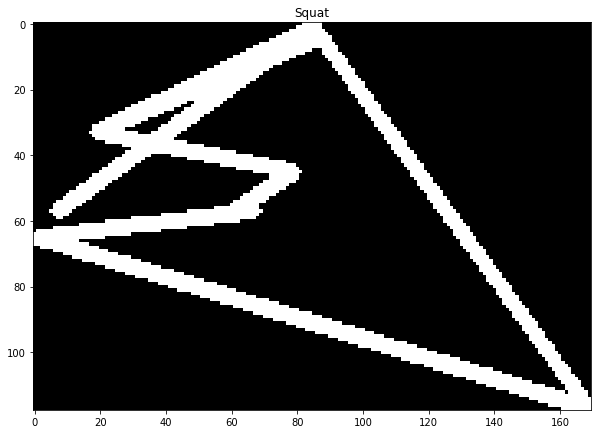

In [16]:


INPUT_IMAGE = "inputs/female_bench.jpg"
inputFrame = cv2.imread(INPUT_IMAGE)
inputBlackImage, outputFrame, inputSlopes = blackImager(inputFrame)
print(inputSlopes)
squats = np.load("squats.npy")
deadlifts = np.load("deadlifts.npy")
benches = np.load("benches.npy")

print("SQUAT")
squatSimilarities = []
for squat in squats:
    ssd = imageComparer(inputSlopes, squat)
    squatSimilarities.append(ssd)
    print(ssd)
squatSimilarity = mean_no_outliers(squatSimilarities)
print(squatSimilarity)
        
print("DEADLIFT")
deadliftSimilarities = []
for deadlift in deadlifts:
    ssd = imageComparer(inputSlopes, deadlift)
    deadliftSimilarities.append(ssd)
    print(ssd)
deadliftSimilarity = mean_no_outliers(deadliftSimilarities)
print(deadliftSimilarity)
        
print("BENCH")
benchSimilarities = []
for bench in benches:
    ssd = imageComparer(inputSlopes, bench)
    benchSimilarities.append(ssd)
    print(ssd)
benchSimilarity = mean_no_outliers(benchSimilarities)
print(benchSimilarity)
        
similarityScores = np.array([squatSimilarity, deadliftSimilarity, benchSimilarity])
exercises = np.array(["Squat", "Deadlift", "Bench"])

minIndex = np.argmin(similarityScores)
exercise = exercises[minIndex]

plt.figure(figsize=[10,10])
plt.title(exercise) 
plt.imshow(cv2.cvtColor(inputBlackImage, cv2.COLOR_BGR2RGB))
    